# German Credit data Exploration and Prediction

This Analysis can be divided into 6 parts:

1. Data Loading

2. Data Exploration

3. Data Preprocessing

4. Model Selection

5. Model Evaluation

6. Conclusion


We will start with Loading the required Libraries and methods

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree  import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
import joblib
# magic word for producing visualizations in notebook
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def groupby_requirement(df, column, value):
    grouped_data = df.groupby([column]).get_group(value)
    length = len(grouped_data)
    return grouped_data , length

In [4]:
def age_count(df):
    young = 0
    old = 0 
    for i in df['Age']:
        if i <= 30:
            young += 1
        else:
            old += 1
    return young, old

In [5]:
def GridSCV_check(Classifier, parameters, X_train, y_train, X_test, y_test):
    #clf = RandomForestClassifier()
    #parameters = {"max_depth" : [1,10,100], 
    #              "min_samples_split" : [6, 8, 10, 12], 
    #              "min_samples_leaf" : [3,4,5]}
    clf = Classifier
    #fbeta_score scoring object using make_scorer()
    scorer = make_scorer(fbeta_score, beta=2)
    #Grid search on the classifier
    grid_obj = GridSearchCV(clf, parameters, scoring = scorer)
    #Fit the grid search object to the training data
    grid_fit = grid_obj.fit(X_train, y_train)
    # Get the estimator
    best_clf = grid_fit.best_estimator_
    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
    return None

In [6]:
def plot_graph(C1, C2, R1, R2, I1, I2, N1, N2):
    study_dataframe = pd.DataFrame(                         
        data={N1:[C1, C2],
              N2:[R1, R2]},
        index=[I1, I2])
    study_dataframe.plot.bar(alpha=0.7)
    plt.ylabel("Total Count")
    return None

In [7]:
def encoding(column, prefix):
    labelencoder = LabelEncoder()
    customers_scaled_log_transformed[column] = labelencoder.fit_transform(
                                customers_scaled_log_transformed[column]
                                )
    encoded_label = dict(zip(labelencoder.transform(labelencoder.classes_), labelencoder.classes_ ))
    name = str('./Models/' + prefix + '_label.pkl' )
    joblib.dump(encoded_label,name)

## 1. Data Loading

First we will load the data from the german.data provided by UCI. The Column value are hardcoded as they are not present in the dataset

In [8]:
file = './data/german.data'
columns = ['Existing account', 
           'Duration month', 
           'Credit history',
           'Purpose',
           'Credit amount',
           'Saving',
           'Employment duration',
           'Installment rate',
           'Personal status',
           'Debtors',
           'Residential Duration',
           'Property',
           'Age',
           'Installment plans',
           'Housing',
           'Number of credits',
           'Job',
           'Liable People',
           'Telephone',
           'Foreign worker',
           'Classification'
          ]
customers = pd.read_csv(file, names = columns, delimiter = ' ')
customers.head()

Existing account  Duration month Credit history Purpose  Credit amount  \
0              A11               6            A34     A43           1169   
1              A12              48            A32     A43           5951   
2              A14              12            A34     A46           2096   
3              A11              42            A32     A42           7882   
4              A11              24            A33     A40           4870   

  Saving Employment duration  Installment rate Personal status Debtors  ...  \
0    A65                 A75                 4             A93    A101  ...   
1    A61                 A73                 2             A92    A101  ...   
2    A61                 A74                 2             A93    A101  ...   
3    A61                 A74                 2             A93    A103  ...   
4    A61                 A73                 3             A93    A101  ...   

   Property Age  Installment plans Housing Number of credits   Job  \
0      A121  67               A143    A152                 2  A173   
1      A121  22               A143    A152                 1  A173   
2      A121  49               A143    A152                 1  A172   
3      A122  45               A143    A153                 1  A173   
4      A124  53               A143    A153                 2  A173   

  Liable People  Telephone Foreign worker Classification  
0             1       A192           A201              1  
1             1       A191           A201              2  
2             2       A191           A201              1  
3             2       A191           A201              1  
4             2       A191           A201              2  

[5 rows x 21 columns]

In [9]:
#Let us do some basic exploration amount the number of 
classification_count = customers.groupby('Classification').count()
classification_count['Existing account']

Classification
1    700
2    300
Name: Existing account, dtype: int64

In [10]:
#Checking if there are any missing values
customers.isnull().sum()

Existing account        0
Duration month          0
Credit history          0
Purpose                 0
Credit amount           0
Saving                  0
Employment duration     0
Installment rate        0
Personal status         0
Debtors                 0
Residential Duration    0
Property                0
Age                     0
Installment plans       0
Housing                 0
Number of credits       0
Job                     0
Liable People           0
Telephone               0
Foreign worker          0
Classification          0
dtype: int64

## 2. Data Exploration

Now we will try to do some data exploration to find meaningful information and along with that will answer the questions asked in the problem statement

### 2.1 Critical Credit History

In [11]:
# We will group Customers according to their classifications First
good_customers, good_customer_length = groupby_requirement(customers, 'Classification', 1)
bad_customers, bad_customer_length = groupby_requirement(customers, 'Classification', 2)

# Now let us try to see each group separately
good_critical_customers , good_critical_customers_length =  groupby_requirement(good_customers, 'Credit history', 'A34')
bad_critical_customers , bad_critical_customers_length= groupby_requirement(bad_customers, 'Credit history', 'A34')

# Let us try to find the percentage of Customers with Critical Credit history with 
# their respective groups
to_print_value = ((good_critical_customers_length/good_customer_length)*100)
print ('Percentage of Good customers with Critical credit History : {}'.format(to_print_value))
to_print_value = ((bad_critical_customers_length/ bad_customer_length)*100)
print ('Percentage of Bad customers with Critical credit History : {}'.format(to_print_value))

# This will print the percentage Good customers with Critical History with 
# respect to all Customers with Critical History
to_print_value =  ((good_critical_customers_length /
                   (good_critical_customers_length + bad_critical_customers_length)) * 100)
print ('Percentage of Good customers with critical credit history out of all customers '
       'with critical credit history : {}'.format(to_print_value))

Percentage of Good customers with Critical credit History : 34.714285714285715
Percentage of Bad customers with Critical credit History : 16.666666666666664
Percentage of Good customers with critical credit history out of all customers with critical credit history : 82.93515358361775


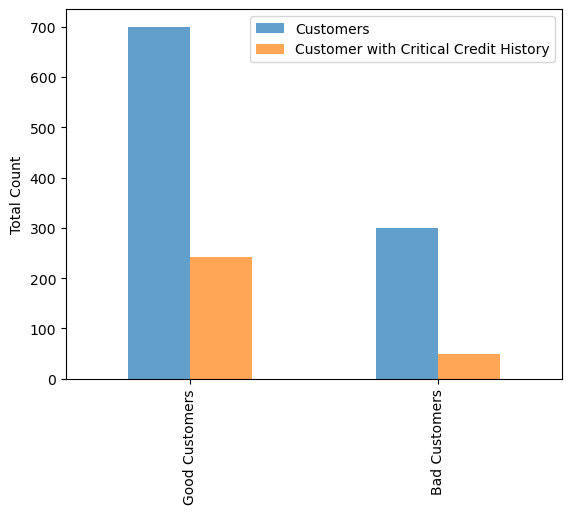

In [12]:
plot_graph(good_customer_length,
           bad_customer_length, 
           good_critical_customers_length, 
           bad_critical_customers_length,
           'Good Customers', 
           'Bad Customers',
           'Customers',
           'Customer with Critical Credit History')

#### Would a person with critical credit history, be more credit worthy?
    
>Here we can see that one of every three good customers have a Critical Credit History. On the other hand, one of every six bad customers have Critical Credit History. Also 4 out of 5 Customers with Critical Credit History are good customers. 
    
>So here we can infer that ***Yes, Critical Credit History indicates that a customer is more Credit worthy***. 

### 2.2 Age 

**Note**: Anyone below and equal to 30 years will be considered young and anyone above 30 years will be considered old

In [13]:
# Here will be categorize good customer according to the age
young_good_customers, old_good_customers = age_count(good_customers)
to_print_value = ((young_good_customers / ( young_good_customers + old_good_customers)) * 100)
print ('Percentage of good young customers out of all good customers : {}'.format(to_print_value))

# Here will be categorize bad customer according to the age
young_bad_customers , old_bad_customers = age_count(bad_customers)
to_print_value =((young_bad_customers / ( young_bad_customers + old_bad_customers)) * 100)
print ('Percentage of bad young customers out of all bad customers : {}'.format(to_print_value))

# Here try to find that what percentage of young customers are good
to_print_value = ((young_good_customers / (young_good_customers + young_bad_customers) )* 100)
print ('Percentage of good young customers out of all young customers : {}'.format(to_print_value))
# Here try to find that what percentage of old customers are good
to_print_value = ((old_good_customers / (old_good_customers + old_bad_customers) )* 100)
print ('Percentage of good old customers out of all old customers : {}'.format(to_print_value))

Percentage of good young customers out of all good customers : 37.57142857142857
Percentage of bad young customers out of all bad customers : 49.333333333333336
Percentage of good young customers out of all young customers : 63.990267639902676
Percentage of good old customers out of all old customers : 74.19354838709677


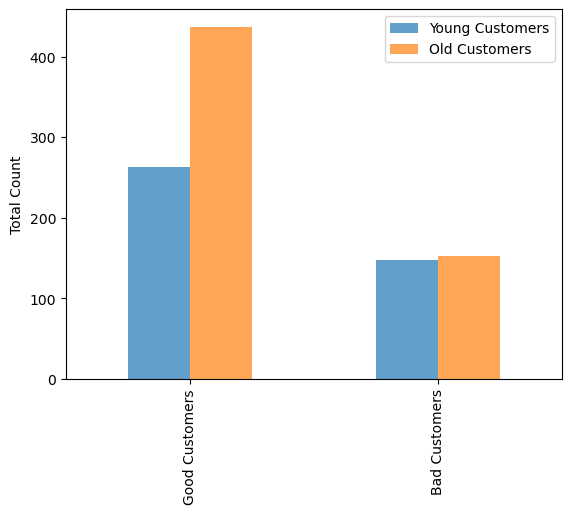

In [14]:
plot_graph(young_good_customers, 
           young_bad_customers,
           old_good_customers,
           old_bad_customers,
           'Good Customers',
           'Bad Customers',
           'Young Customers',
           'Old Customers'
           )

#### Are young people more credit worthy?
    
>Here we can see that 3 out of 4 Old Customers are Credit Worthy. On the other hand, 6 of every 10 young customers credit worthy. Also there is 50% chance that if the customer is categorised as bad customer then he/she is young. 
    
>So here we can infer that ***Old customers are more credit worthy than young people***. 

### 2.3 Credit accounts


In [15]:
# Let us see how many distinct values are present for number of Credits column
num = set(good_customers['Number of credits'])
num

{1, 2, 3, 4}

In [16]:
good_customers_with_3_credits, good_3_credit = groupby_requirement(good_customers, 'Number of credits', 3)
good_customers_with_4_credits, good_4_credit = groupby_requirement(good_customers, 'Number of credits', 4)

customers_with_3_credits, all_3_credit = groupby_requirement(customers, 'Number of credits', 3)
customers_with_4_credits, all_4_credit = groupby_requirement(customers, 'Number of credits', 4)

((good_3_credit + good_4_credit)/(all_3_credit + all_4_credit))*100
to_print_value = (((good_3_credit + good_4_credit)/(all_3_credit + all_4_credit))*100)
print ('Percentage of good customers with more than 3 credit accounts '
       'out of all customers with more that 3 credit accounts: {}'.format(to_print_value))

Percentage of good customers with more than 3 credit accounts out of all customers with more that 3 credit accounts: 76.47058823529412


#### Would a person with more credit accounts, be more credit worthy?
    
>Here we can see that 3 out of 4 good customer have more than 2 credit accounts. 
    
>So here we can infer that ***Customers with more than 2 credits accounts are credit worthy***.

### 2.4 Consolidated view of the data using Swarm graph

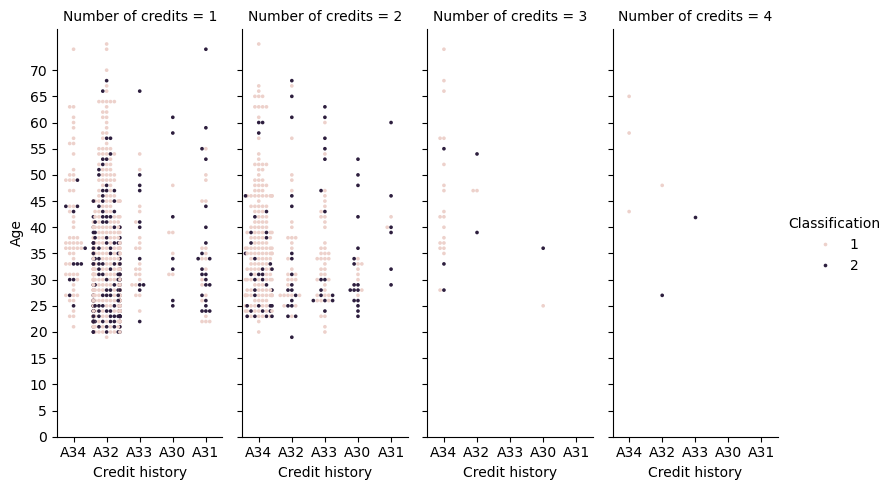

In [19]:
sns.catplot(data=customers, 
               col='Number of credits', 
               x='Credit history', 
               y='Age', 
               hue='Classification', 
               kind='swarm',  aspect=0.4, s=7)
plt.yticks(np.arange(0,75,5));

### Take away points from the graph above:
> **More the number of Credit accounts more the probabilility of Credit worthiness**

> **Critical credit History depict higher credit worthiness**

> **Anyone with two credit accounts with critical credit history(A34) and between the age 31 to 65 has high likelyhood of high credit worthiness**

## 3. Data Preprocessing 

In [20]:
#Separating Data from the Label
label = customers['Classification']
customers = customers.drop('Classification', axis = 1)
numeric_columns = customers.describe().columns

#### Now Let us plot pairplot graph to see correlation of the columns

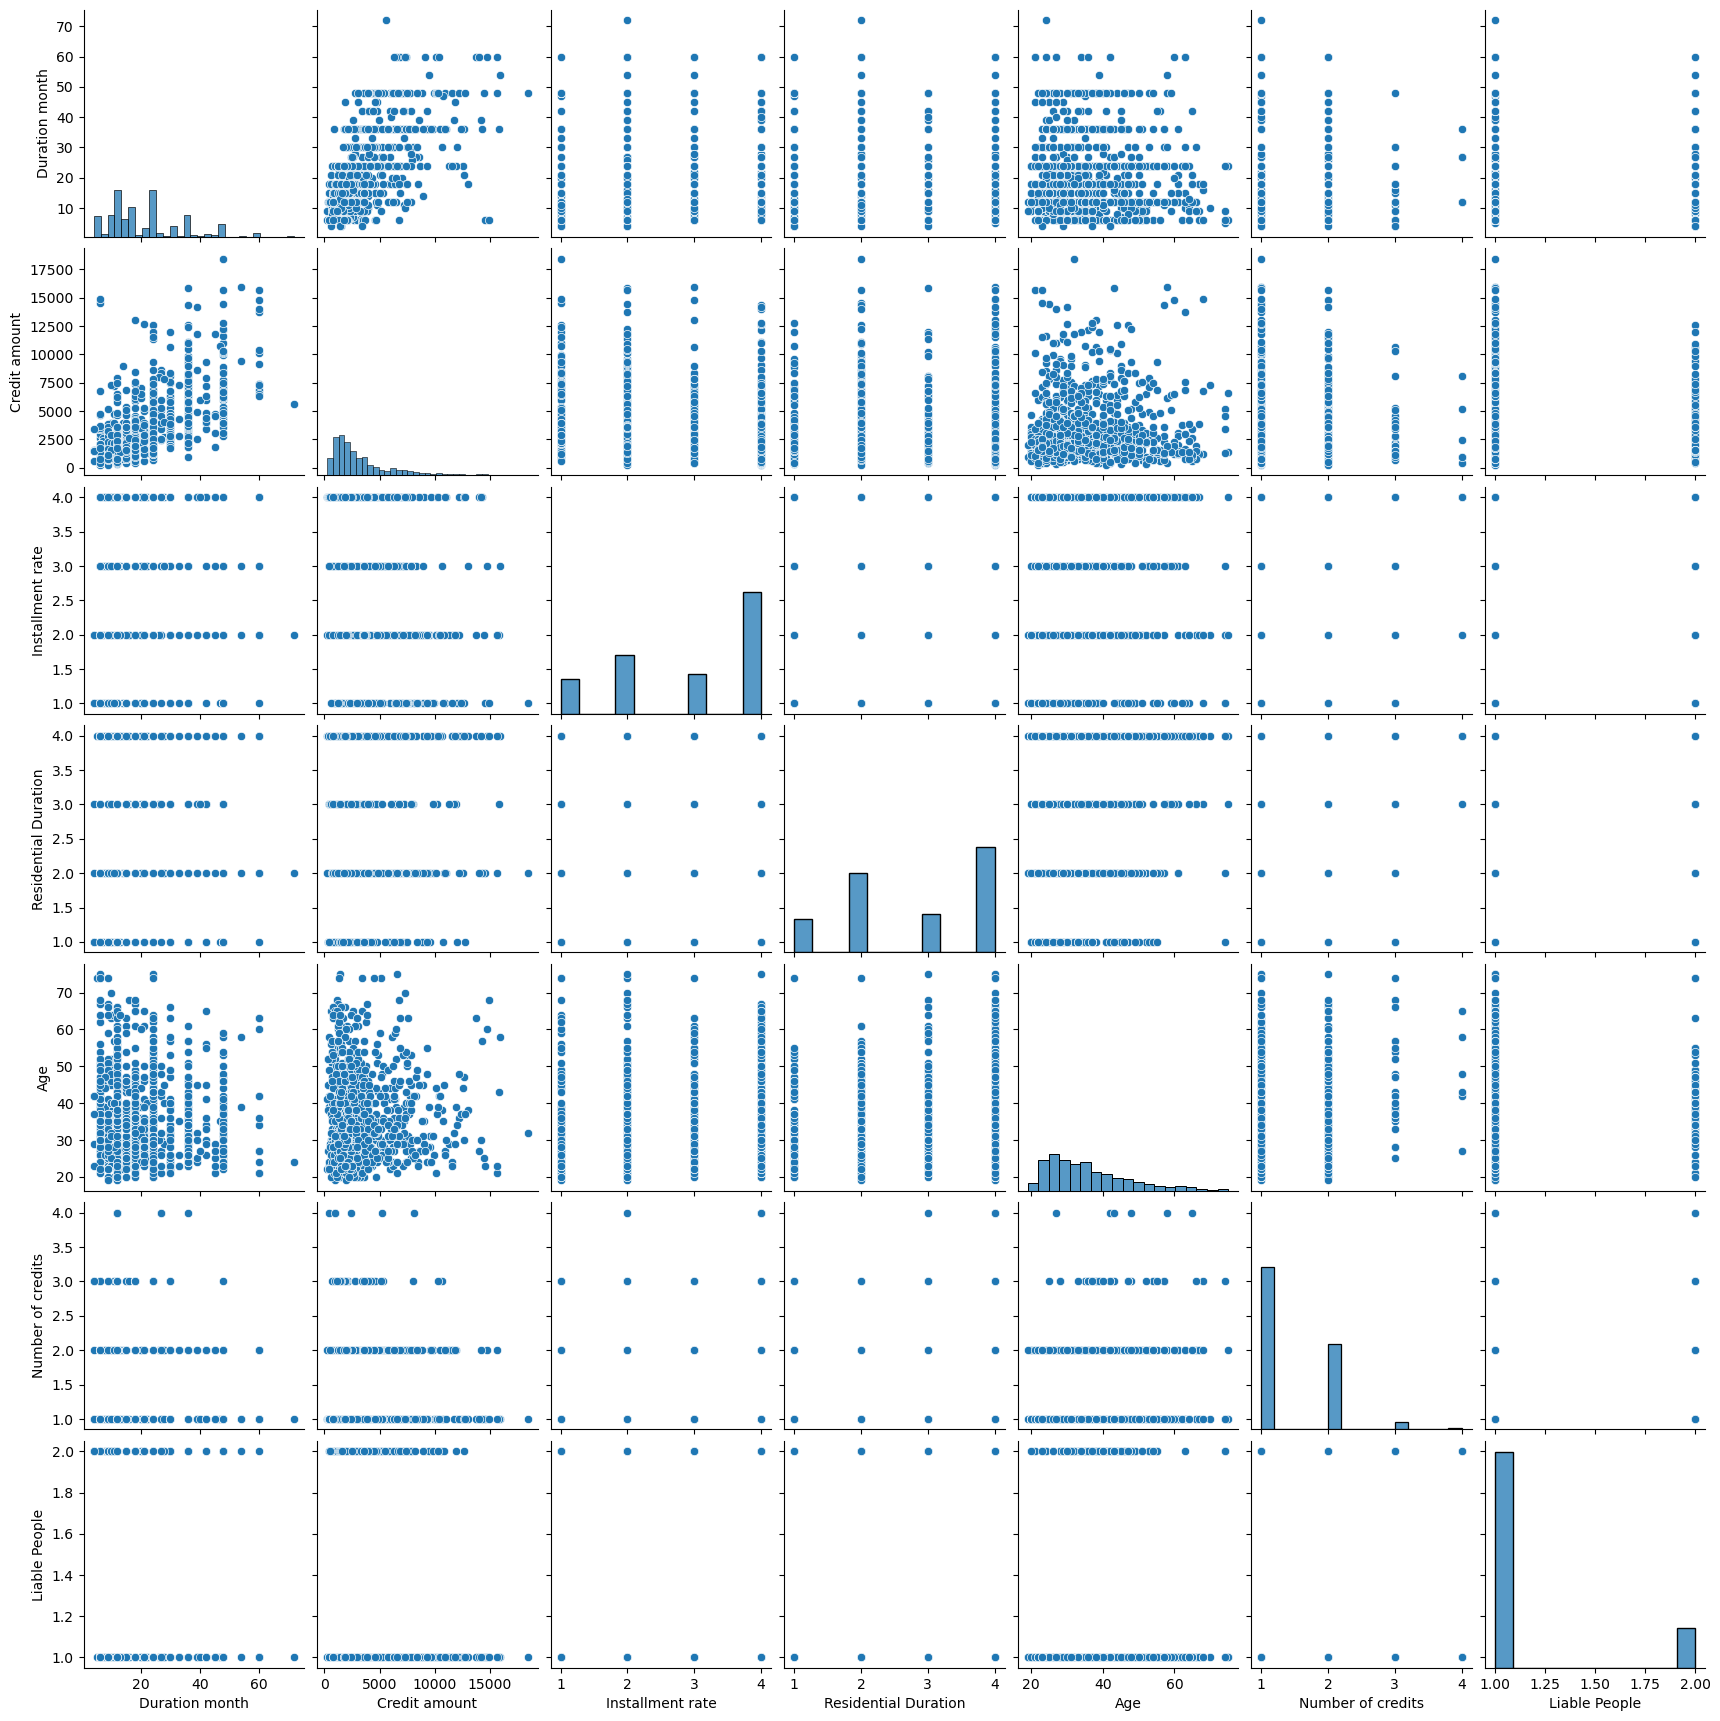

In [21]:
#Let us try to see if the columns in the dataframes are correlated
sns.pairplot(customers[numeric_columns])

#### From the Graph above we can notice a few things

> 1. Credit amount and Duration Month are directly related. So with increase of Duration month and Credit amount is also Increasing

> 2. Age along with Duration Month and Credit amount are right skewed with most of the datapoints located at the start of the graph

<Axes: xlabel='Age', ylabel='Density'>

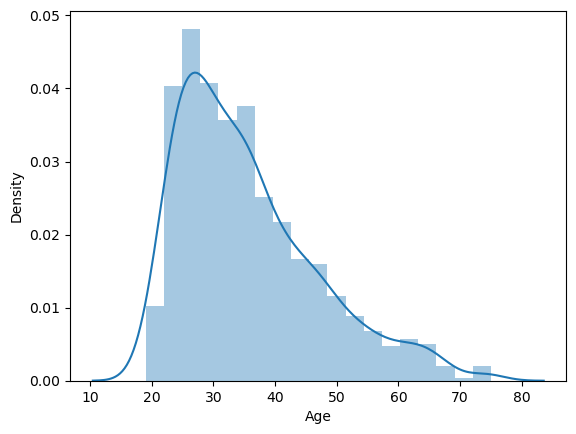

In [22]:
sns.distplot(customers['Age'])

##### The plot above is right skewed with one peak

<Axes: xlabel='Credit amount', ylabel='Density'>

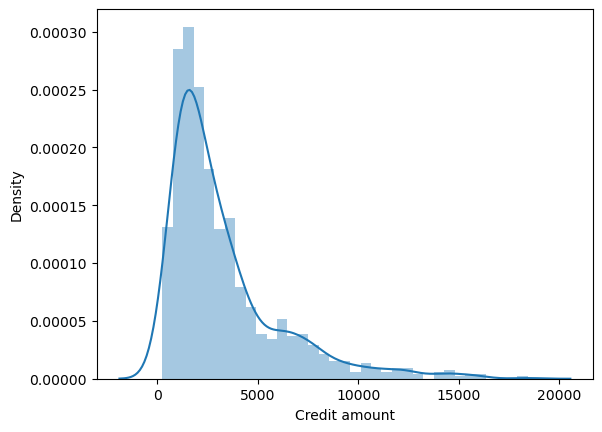

In [23]:
sns.distplot(customers['Credit amount'])

##### The plot above is also right skewed 

<Axes: xlabel='Duration month', ylabel='Density'>

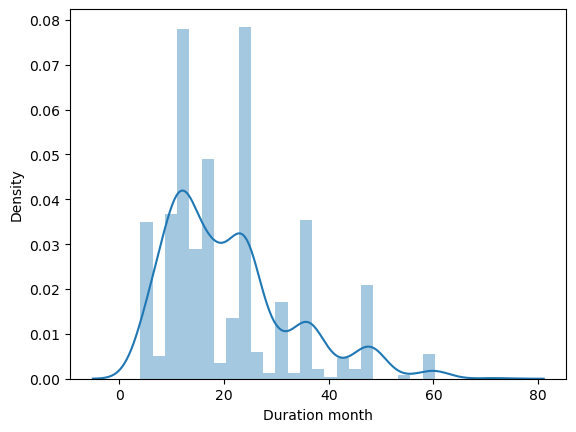

In [24]:
sns.distplot(customers['Duration month'])

##### The plot above is also right skewed with multiple peaks

### 3.1 Logarithmic Transform

> As noticed above there are columns with Skewed data. So we will preform Logarithmic transform to reduce the impact of very large or very small values on the learning Algorithm

In [25]:
# Here we will perform Log transform of all the numeric columns of create a redistributed graph
customers_log_transformed = customers.copy()
customers_log_transformed[numeric_columns] = customers[numeric_columns].apply(lambda x: np.log(x + 1))
customers_log_transformed

Existing account  Duration month Credit history Purpose  Credit amount  \
0                A11        1.945910            A34     A43       7.064759   
1                A12        3.891820            A32     A43       8.691483   
2                A14        2.564949            A34     A46       7.648263   
3                A11        3.761200            A32     A42       8.972464   
4                A11        3.218876            A33     A40       8.491055   
..               ...             ...            ...     ...            ...   
995              A14        2.564949            A32     A42       7.459915   
996              A11        3.433987            A32     A41       8.257904   
997              A14        2.564949            A32     A43       6.690842   
998              A11        3.828641            A32     A43       7.520776   
999              A12        3.828641            A34     A41       8.428799   

    Saving Employment duration  Installment rate Personal status Debtors  \
0      A65                 A75          1.609438             A93    A101   
1      A61                 A73          1.098612             A92    A101   
2      A61                 A74          1.098612             A93    A101   
3      A61                 A74          1.098612             A93    A103   
4      A61                 A73          1.386294             A93    A101   
..     ...                 ...               ...             ...     ...   
995    A61                 A74          1.386294             A92    A101   
996    A61                 A73          1.609438             A91    A101   
997    A61                 A75          1.609438             A93    A101   
998    A61                 A73          1.609438             A93    A101   
999    A62                 A71          1.386294             A93    A101   

     Residential Duration Property       Age Installment plans Housing  \
0                1.609438     A121  4.219508              A143    A152   
1                1.098612     A121  3.135494              A143    A152   
2                1.386294     A121  3.912023              A143    A152   
3                1.609438     A122  3.828641              A143    A153   
4                1.609438     A124  3.988984              A143    A153   
..                    ...      ...       ...               ...     ...   
995              1.609438     A121  3.465736              A143    A152   
996              1.609438     A122  3.713572              A143    A152   
997              1.609438     A123  3.663562              A143    A152   
998              1.609438     A124  3.178054              A143    A153   
999              1.609438     A123  3.332205              A143    A152   

     Number of credits   Job  Liable People Telephone Foreign worker  
0             1.098612  A173       0.693147      A192           A201  
1             0.693147  A173       0.693147      A191           A201  
2             0.693147  A172       1.098612      A191           A201  
3             0.693147  A173       1.098612      A191           A201  
4             1.098612  A173       1.098612      A191           A201  
..                 ...   ...            ...       ...            ...  
995           0.693147  A172       0.693147      A191           A201  
996           0.693147  A174       0.693147      A192           A201  
997           0.693147  A173       0.693147      A191           A201  
998           0.693147  A173       0.693147      A192           A201  
999           0.693147  A173       0.693147      A191           A201  

[1000 rows x 20 columns]

##### Now let us Pairplot again to check if the distribution has been normalized

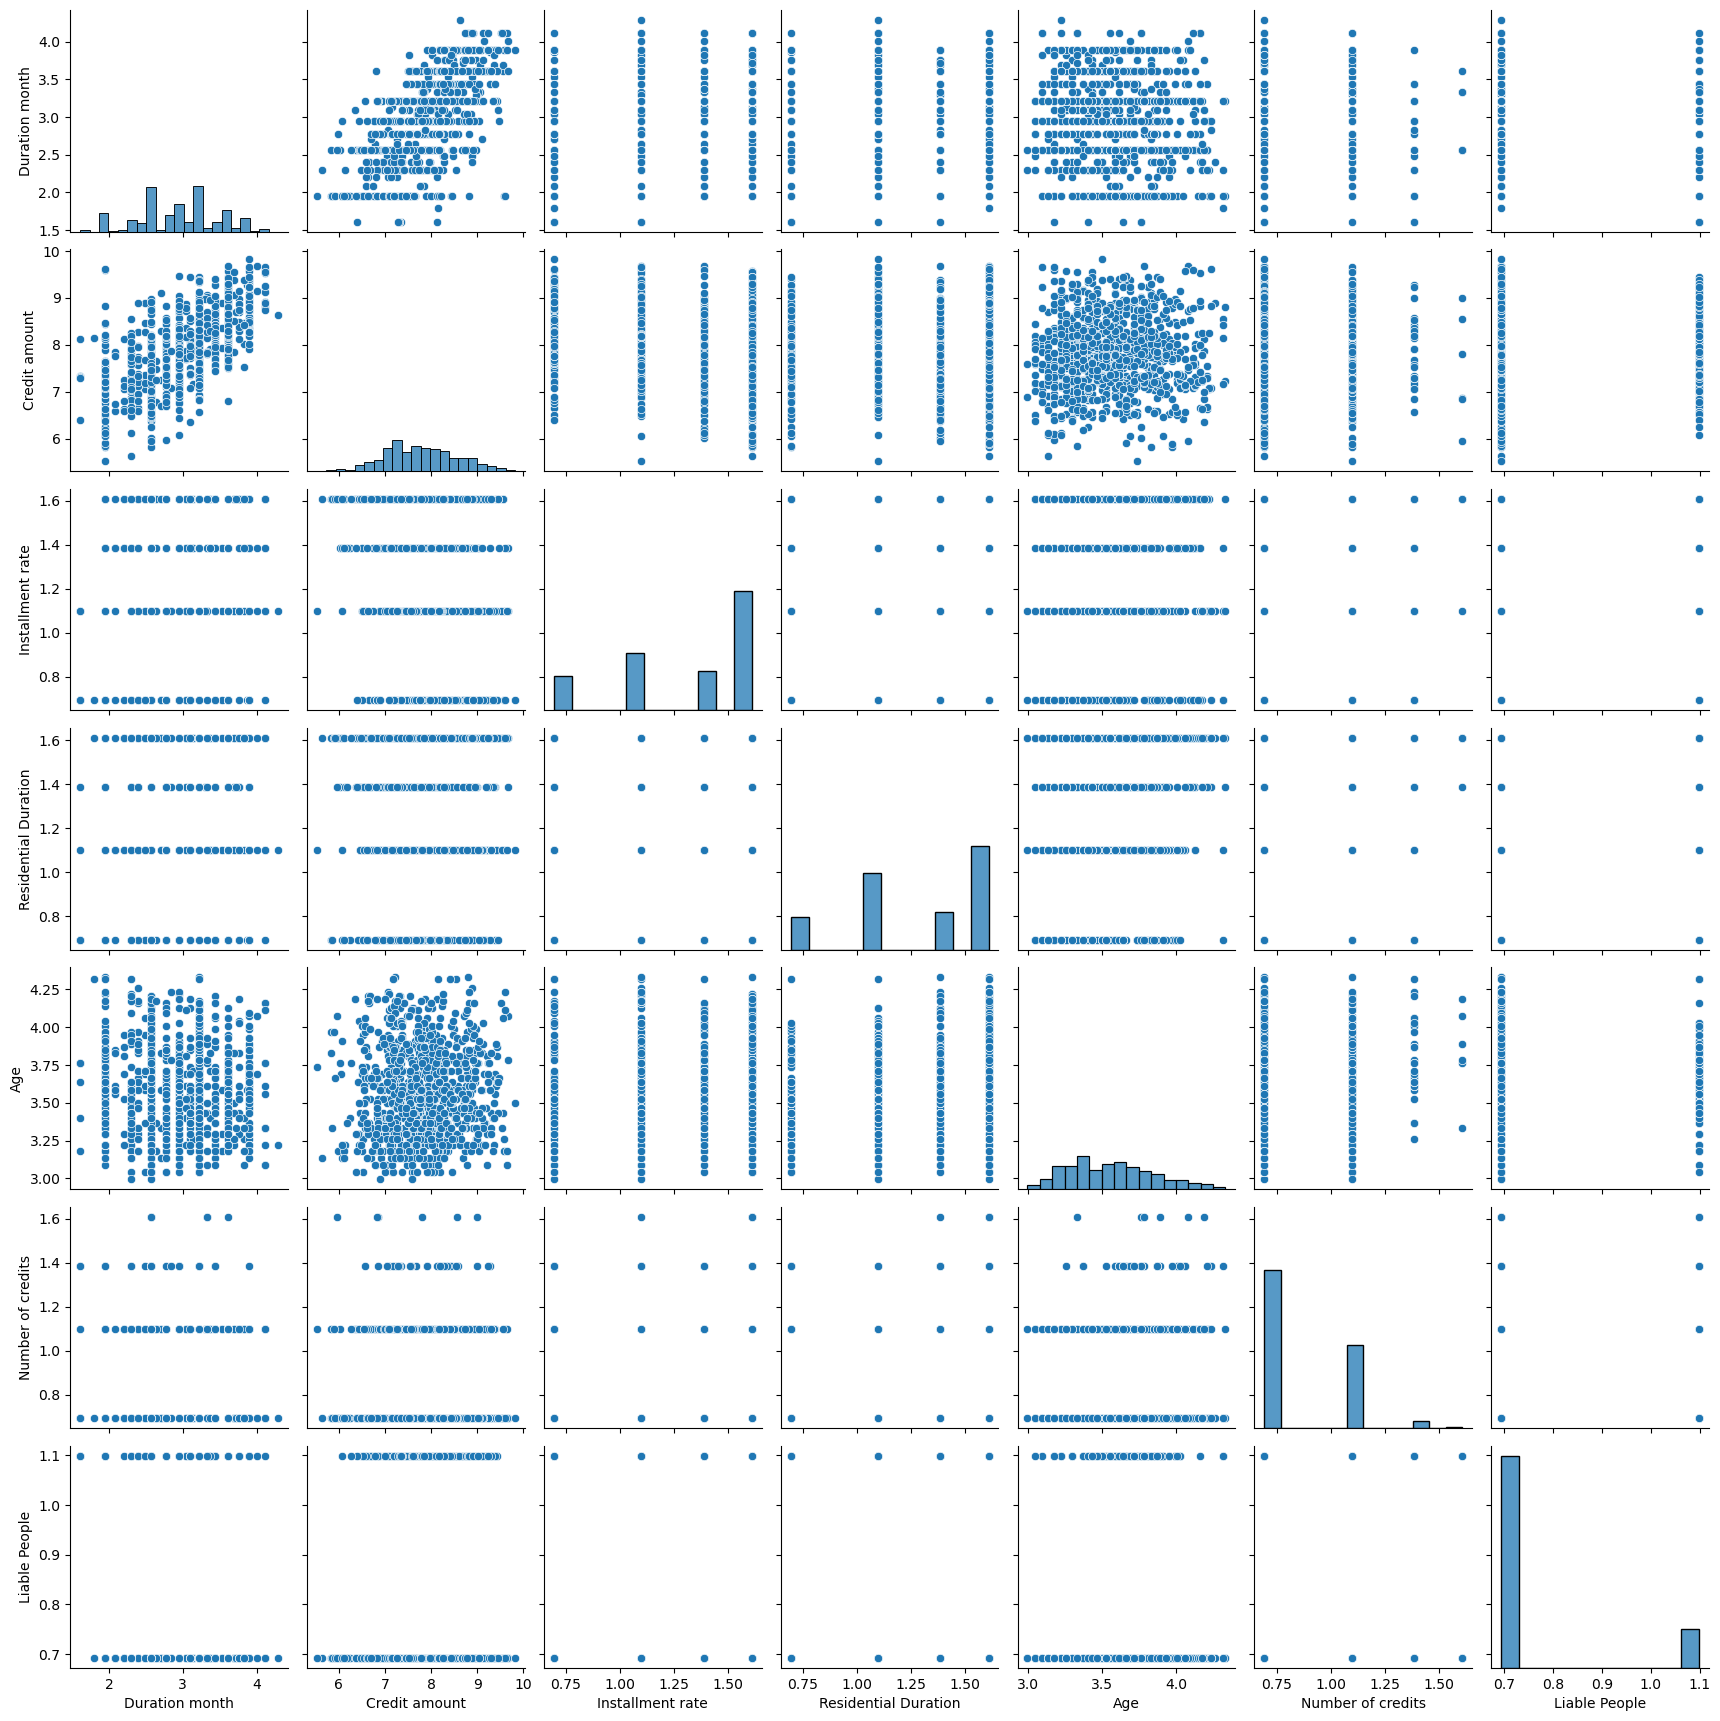

In [26]:
sns.pairplot(customers_log_transformed[numeric_columns])

### 3.2 Min Max Scaling

> As there are numeric values present in the data we will perform Min Max Scaling to normalize the data. There is another way of doing this know as **Standard Scaling** which uses Mean and Standard deviation to produce the normalized data

In [27]:
scaler = MinMaxScaler()
customers_scaled_log_transformed = customers_log_transformed.copy()
customers_scaled_log_transformed[numeric_columns] = scaler.fit_transform(customers_scaled_log_transformed[numeric_columns])
customers_scaled_log_transformed

Existing account  Duration month Credit history Purpose  Credit amount  \
0                A11        0.125502            A34     A43       0.358311   
1                A12        0.851311            A32     A43       0.736970   
2                A14        0.356398            A34     A46       0.494135   
3                A11        0.802590            A32     A42       0.802375   
4                A11        0.600308            A33     A40       0.690315   
..               ...             ...            ...     ...            ...   
995              A14        0.356398            A32     A42       0.450293   
996              A11        0.680543            A32     A41       0.636044   
997              A14        0.356398            A32     A43       0.271272   
998              A11        0.827745            A32     A43       0.464460   
999              A12        0.827745            A34     A41       0.675824   

    Saving Employment duration  Installment rate Personal status Debtors  \
0      A65                 A75          1.000000             A93    A101   
1      A61                 A73          0.442507             A92    A101   
2      A61                 A74          0.442507             A93    A101   
3      A61                 A74          0.442507             A93    A103   
4      A61                 A73          0.756471             A93    A101   
..     ...                 ...               ...             ...     ...   
995    A61                 A74          0.756471             A92    A101   
996    A61                 A73          1.000000             A91    A101   
997    A61                 A75          1.000000             A93    A101   
998    A61                 A73          1.000000             A93    A101   
999    A62                 A71          0.756471             A93    A101   

     Residential Duration Property       Age Installment plans Housing  \
0                1.000000     A121  0.916685              A143    A152   
1                0.442507     A121  0.104691              A143    A152   
2                0.756471     A121  0.686360              A143    A152   
3                1.000000     A122  0.623901              A143    A153   
4                1.000000     A124  0.744008              A143    A153   
..                    ...      ...       ...               ...     ...   
995              1.000000     A121  0.352062              A143    A152   
996              1.000000     A122  0.537707              A143    A152   
997              1.000000     A123  0.500246              A143    A152   
998              1.000000     A124  0.136570              A143    A153   
999              1.000000     A123  0.252039              A143    A152   

     Number of credits   Job  Liable People Telephone Foreign worker  
0             0.442507  A173            0.0      A192           A201  
1             0.000000  A173            0.0      A191           A201  
2             0.000000  A172            1.0      A191           A201  
3             0.000000  A173            1.0      A191           A201  
4             0.442507  A173            1.0      A191           A201  
..                 ...   ...            ...       ...            ...  
995           0.000000  A172            0.0      A191           A201  
996           0.000000  A174            0.0      A192           A201  
997           0.000000  A173            0.0      A191           A201  
998           0.000000  A173            0.0      A192           A201  
999           0.000000  A173            0.0      A191           A201  

[1000 rows x 20 columns]

### 3.3 One-Hot Encoding Data

> As there are a lot of non Numeric (categorical) columns. We will preform **LabelEncoding** to convert Categorical column into machine readable data

In [28]:
encoding('Existing account', 'ea')
encoding('Credit history', 'ch')
encoding('Purpose', 'pr')
encoding('Saving', 'sa')
encoding('Employment duration', 'ed')
encoding('Personal status', 'ps')
encoding('Debtors', 'db')
encoding('Property', 'pt')
encoding('Installment plans', 'ip')
encoding('Housing', 'ho')
encoding('Job', 'jb')
encoding('Telephone', 'tp')
encoding('Foreign worker', 'fw')

In [29]:
customers_final = customers_scaled_log_transformed.copy()
customers_final

Existing account  Duration month  Credit history  Purpose  Credit amount  \
0                   0        0.125502               4        4       0.358311   
1                   1        0.851311               2        4       0.736970   
2                   3        0.356398               4        7       0.494135   
3                   0        0.802590               2        3       0.802375   
4                   0        0.600308               3        0       0.690315   
..                ...             ...             ...      ...            ...   
995                 3        0.356398               2        3       0.450293   
996                 0        0.680543               2        1       0.636044   
997                 3        0.356398               2        4       0.271272   
998                 0        0.827745               2        4       0.464460   
999                 1        0.827745               4        1       0.675824   

     Saving  Employment duration  Installment rate  Personal status  Debtors  \
0         4                    4          1.000000                2        0   
1         0                    2          0.442507                1        0   
2         0                    3          0.442507                2        0   
3         0                    3          0.442507                2        2   
4         0                    2          0.756471                2        0   
..      ...                  ...               ...              ...      ...   
995       0                    3          0.756471                1        0   
996       0                    2          1.000000                0        0   
997       0                    4          1.000000                2        0   
998       0                    2          1.000000                2        0   
999       1                    0          0.756471                2        0   

     Residential Duration  Property       Age  Installment plans  Housing  \
0                1.000000         0  0.916685                  2        1   
1                0.442507         0  0.104691                  2        1   
2                0.756471         0  0.686360                  2        1   
3                1.000000         1  0.623901                  2        2   
4                1.000000         3  0.744008                  2        2   
..                    ...       ...       ...                ...      ...   
995              1.000000         0  0.352062                  2        1   
996              1.000000         1  0.537707                  2        1   
997              1.000000         2  0.500246                  2        1   
998              1.000000         3  0.136570                  2        2   
999              1.000000         2  0.252039                  2        1   

     Number of credits  Job  Liable People  Telephone  Foreign worker  
0             0.442507    2            0.0          1               0  
1             0.000000    2            0.0          0               0  
2             0.000000    1            1.0          0               0  
3             0.000000    2            1.0          0               0  
4             0.442507    2            1.0          0               0  
..                 ...  ...            ...        ...             ...  
995           0.000000    1            0.0          0               0  
996           0.000000    3            0.0          1               0  
997           0.000000    2            0.0          0               0  
998           0.000000    2            0.0          1               0  
999           0.000000    2            0.0          0               0  

[1000 rows x 20 columns]

In [30]:
#customers_final.to_csv('./data/clean_customer_data.csv')
clean_data = pd.concat([customers_final, label],  axis=1, join='inner')
customers_final.to_csv('clean_customer_data.csv')

### 3.4 Splitting the data into Test and Train datasets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(customers_final, 
                                                    label, 
                                                    test_size = 0.25, 
                                                    random_state = 1)

## 4. Model Selection 

### Here we will select 3 models and then will try to find the best model to implement

From all the available supervised learning models we have chosen only 3 : 

1. Random Forest Classifier

2. Logistic Regression

3. Support Vector machines

### 4.1 Random Forest Classifier

In [32]:
# Declaring the Classifier
Randon_forest_clf = RandomForestClassifier()

# Fit the Classifier object on Input data
Random_forest_model = Randon_forest_clf.fit(X_train, y_train)

# Predict the Values on test data
Randon_forest_pred = Random_forest_model.predict(X_test)

# Calculate the Probalities for each Prediction
Randon_forest_proba = Random_forest_model.predict_proba(X_test)

# Calculate the accuracy of the Classifier
Random_forest_accuracy = accuracy_score(y_test, Randon_forest_pred) 

### 4.2 Logistic Regression Classifier

In [33]:
# Declaring the Classifier
Logistic_regression_clf = LogisticRegression()

# Fit the Classifier object on Input data
Logistic_regression_model = Logistic_regression_clf.fit(X_train, y_train)

# Predict the Values on test data
Logistic_regression_pred = Logistic_regression_model.predict(X_test)

# Calculate the Probalities for each Prediction
Logistic_regression_proba = Logistic_regression_model.predict_proba(X_test)

# Calculate the accuracy of the Classifier
Logistic_regression_accuracy = accuracy_score(y_test, Logistic_regression_pred)

### 4.3 Support Vector Machine Classifier

In [34]:
# Declaring the Classifier
SVC_clf = SVC(kernel = 'linear',probability = True)

# Fit the Classifier object on Input data
SVC_model = SVC_clf.fit(X_train, y_train)

# Predict the Values on test data
SVC_pred = SVC_model.predict(X_test)

# Calculate the Probalities for each Prediction
SVC_proba = SVC_model.predict_proba(X_test)

# Calculate the accuracy of the Classifier
SVC_accuracy = accuracy_score(y_test, SVC_pred) 

In [35]:
print('Accuracy of Random Forest Classifier is {}'.format(Random_forest_accuracy))
print('Accuracy of Logistic Regression Classifier is {}'.format(Logistic_regression_accuracy))
print('Accuracy of Support Vector Machine Classifier is {}'.format(SVC_accuracy))

Accuracy of Random Forest Classifier is 0.764
Accuracy of Logistic Regression Classifier is 0.784
Accuracy of Support Vector Machine Classifier is 0.776


> One thing to keep in our minds is to decide which Matrics to use here.
> The output here uses a Cost matrix where penalty to have a **False Negative is higher than that of False Positive**. This means that for a bank **the cost to loan a misclassified bad customer is higher than the cost of loan rejected for a good customer**. Therefore we will try to **Reduce** the False Negatives. This actually means we will have to have a **large Recall so that False Negatives are minimized**. 

> Cost Matrix

|        | Good   | Bad  |
| :---   | :----: | ---: |
| Good   | 0      | 1    |
| Bad    | 5      | 0    |

    (1 = Good,  2 = Bad)
    The rows represent the actual classification and the columns the predicted classification.

> So to evaluate the models to have large recall we will use Fbeta Score. Formula for Fbeta Score is 
((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall). Here when the value of beta is greater that '1' , it will weight more attention on Recall than Precision. Therefore we will use beta as '2'.

In [36]:
#Now Calculating Fbeta Score 
Random_forest_fbeta = fbeta_score(y_test, Randon_forest_pred, beta = 2)
Logistic_regression_fbeta = fbeta_score(y_test, Logistic_regression_pred, beta = 2)
SVC_fbeta = fbeta_score(y_test, SVC_pred, beta = 2)

In [37]:
print('Fbeta Score of Random Forest Classifier is {}'.format(Random_forest_fbeta))
print('Fbeta Score of Logistic Regression Classifier is {}'.format(Logistic_regression_fbeta))
print('Fbeta Score of Support Vector Machine Classifier is {}'.format(SVC_fbeta))

Fbeta Score of Random Forest Classifier is 0.8961748633879781
Fbeta Score of Logistic Regression Classifier is 0.8975770925110133
Fbeta Score of Support Vector Machine Classifier is 0.8991228070175439


## 5. Model Evaluation

### 5.1 ROC Curve

> We can see here that the Fbeta score Random Forest has is better than the other two. While the  Accuracy of Logistic Regression is better. So we will Drop SVM algorithm and try to find the best from Random Forest and Logistic Regression. 

> To do that we will plot the **ROC curve** to see which one is consistant

0.7863175675675675
0.792997542997543


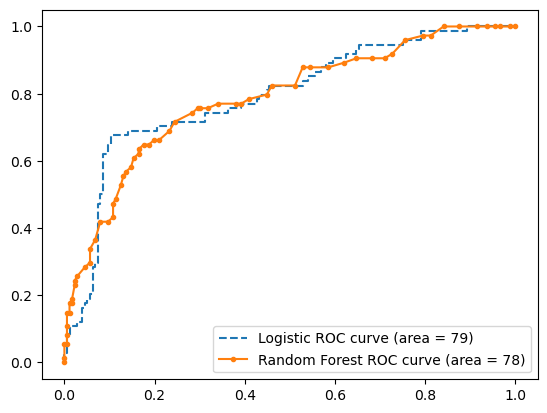

In [38]:
rf_probs = Randon_forest_proba[:,1]
lr_probs = Logistic_regression_proba[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs, pos_label=2)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs, pos_label=2)
rf_auc = roc_auc_score(y_test, rf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
lr_label = str('Logistic ROC curve (area = {})'.format(int(lr_auc*100)))
rf_label = str('Random Forest ROC curve (area = {})'.format(int(rf_auc*100)))
plt.plot(lr_fpr, lr_tpr, linestyle='--', label=lr_label)
plt.plot(rf_fpr, rf_tpr, marker='.', label=rf_label)
rf_auc = roc_auc_score(y_test, rf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print (rf_auc)
print (lr_auc)
plt.legend()
plt.show()

### 5.2 GridSearchCV

> We can see Random Forest is consistant. To verify further we will use **GridSearchCV** to predict the credit worthiness using the combination of best hyperparameters for both the Classifiers.

In [39]:
#Grid Search for Random Forest Classifier

Classifier = RandomForestClassifier()
parameters = {"max_depth" : [1,10,100], 
              "min_samples_split" : [6, 8, 10, 12], 
              "min_samples_leaf" : [3,4,5]}

GridSCV_check(Classifier, parameters, X_train, y_train, X_test, y_test)

Unoptimized model
------
Accuracy score on testing data: 0.7720
F-score on testing data: 0.8946

Optimized Model
------
Final accuracy score on the testing data: 0.7040
Final F-score on the testing data: 0.9224


In [40]:
#Grid Search for Logistic Regression
Classifier = LogisticRegression()
parameters = {"C" : [0.01,0.1, 1,10,100], 
              "penalty" : ['l1', 'l2'], 
              "class_weight":['balanced']}
GridSCV_check(Classifier, parameters, X_train, y_train, X_test, y_test)

Unoptimized model
------
Accuracy score on testing data: 0.7840
F-score on testing data: 0.8976

Optimized Model
------
Final accuracy score on the testing data: 0.7440
Final F-score on the testing data: 0.7710


> From the evaluation above we can see that both the optimized models have equal evaluation matrics. Final accuracy score for both the models was 0.71 and Fbeta score was 0.92. But as we have see that even without optimization, Fbeta score of Random forest is better and therefore we will be choose ***Random forest*** for this dataset prediction

In [41]:
joblib.dump(Logistic_regression_model,'model.joblib')

['Selected_Model.pkl']

In [ ]:
from google.cloud import storage
storage_client = storage.Client()
bucket = storage_client.bucket("test_german_data")
model_artifact = bucket.blob('model-artifact/'+'model.joblib')
model_artifact.upload_from_filename('model.joblib')